In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from dust_extinction.averages import CT06_MWGC, RL85_MWGC, RRP89_MWGC, F11_MWGC, I05_MWAvg, CT06_MWLoc, G21_MWAvg
import regions
from regions import Regions

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import JWSTCatalog
from jwst_plots import make_cat_use
import cutout_manager as cm

In [4]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
cat_use = make_cat_use()

# Open Model

In [6]:
trilegal_fn = '/home/savannahgramze/orange_link/adamginsburg/jwst/cloudc/trilegal/trilegal_nircam.dat'
#, format='ascii.csv', delimiter=' '

In [ ]:
#trilegal = Table.read(trilegal_fn, format='ascii.csv', delimiter=' ')

In [7]:
trilegal = pd.read_csv(trilegal_fn, sep='\s+', header=0)#, nrows=10000000)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/scratch/local/49718920/ipykernel_2575050/632579134.py:1: SyntaxWarning: invalid escape sequence '\s'
  trilegal = pd.read_csv(trilegal_fn, sep='\s+', header=0)#, nrows=10000000)


In [8]:
trilegal.size

488254760

In [9]:
area = 0.1 * u.deg**2
area.to(u.arcsec**2)

<Quantity 1296000. arcsec2>

In [70]:
basepath = '/orange/adamginsburg/jwst/cloudc/'
#fn_405 = f'{basepath}/images/F405_reproj_merged-fortricolor.fits'
fn_405 = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'

ww = WCS(fits.open(fn_405)[0].header)
data_405 = fits.getdata(fn_405)
#image_area = data_405.size * ww.proj_plane_pixel_area().to(u.arcsec**2)
image_area = np.sum((data_405 != 0) & (np.isnan(data_405) == False)) * ww.proj_plane_pixel_area().to(u.arcsec**2)
print(image_area)

area_cat = image_area

70265.9036456803 arcsec2


In [11]:
trilegal.columns

Index(['#Gc', 'logAge', '[M/H]', 'm_ini', 'logL', 'logTe', 'logg', 'm-M0',
       'Av', 'm2/m1', 'mbol', 'F070W', 'F090W', 'F115W', 'F150W', 'F200W',
       'F277W', 'F356W', 'F444W', 'F150W2', 'F322W2', 'F140M', 'F162M',
       'F182M', 'F210M', 'F250M', 'F300M', 'F335M', 'F360M', 'F410M', 'F430M',
       'F460M', 'F480M', 'F150WS60', 'Mact'],
      dtype='object')

# Find Distance

In [12]:
def get_A_lambda(wavelength, Av, ext=CT06_MWGC()):
    return Av * ext(wavelength)

In [13]:
def apply_extinction(trilegal, ext=CT06_MWGC(), factor=1.0):
    dAvdr = 0.002 / u.pc # units of magnitude/pc

    distance = 10**(trilegal['m-M0']/5 + 1)

    trilegal['distance'] = distance

    trilegal['Av'] = Av =  dAvdr * distance * factor

    # Apply extinction law
    trilegal['eF182M'] = trilegal['F182M'] + get_A_lambda(1.82*u.um, Av, ext=ext)
    trilegal['eF210M'] = trilegal['F210M'] + get_A_lambda(2.10*u.um, Av, ext=ext)
    trilegal['eF410M'] = trilegal['F410M'] + get_A_lambda(4.10*u.um, Av, ext=ext)
    trilegal['eF460M'] = trilegal['F460M'] + get_A_lambda(4.60*u.um, Av, ext=ext)

apply_extinction(trilegal, ext=RRP89_MWGC(), factor=1)

#ext = CT06_MWGC()
#ext = RL85_MWGC()
#ext = RRP89_MWGC()
#ext = F11_MWGC()

sel = (trilegal['eF182M'] < 20) & (trilegal['eF182M'] > 13) #& ((trilegal['F182M'] - trilegal['F410M']) < 3) & ((trilegal['F182M'] - trilegal['F410M']) > 0)
sel_cat = (cat_use.band('F182M') < 20) & (cat_use.band('F182M') > 13) #& (cat_use.color('F182M', 'F410M') < 3) & (cat_use.color('F182M', 'F410M') > 0)

masked_cat_use = JWSTCatalog(cat_use.catalog[sel_cat])

color_182_410 = trilegal['eF182M'] - trilegal['eF410M']
color_182_410_cat = masked_cat_use.band('F182M') - masked_cat_use.band('F410M')



## CMD Plots

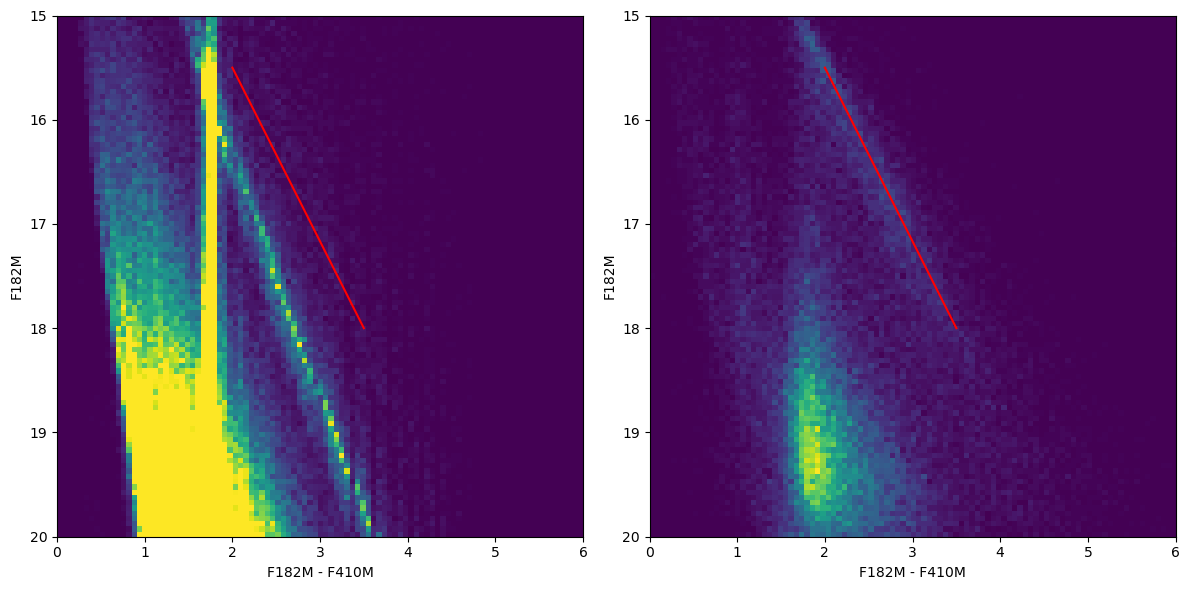

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bins_x = np.linspace(0, 6, 100)
bins_y = np.linspace(15, 20, 100)

h_trilegal, _, __ = np.histogram2d(color_182_410, trilegal['eF182M'], bins=(bins_x, bins_y))
h_cat_use, _, __ = np.histogram2d(cat_use.band('F182M') - cat_use.band('F410M'), cat_use.band('F182M'), bins=(bins_x, bins_y))

h_trilegal = h_trilegal.swapaxes(0, 1)
h_cat_use = h_cat_use.swapaxes(0, 1)

h_trilegal = np.flipud(h_trilegal)
h_cat_use = np.flipud(h_cat_use)

# Plot the 2D histogram for the trilegal data
ax1.imshow(h_trilegal, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 20, 15), vmin=0, vmax=np.max(h_cat_use))
ax1.plot([2, 3.5], [15.5, 18], color='red')
#plt.gca().invert_yaxis()
ax1.set_xlabel('F182M - F410M')
ax1.set_ylabel('F182M')
#fig.colorbar(h1[3], ax=ax1, label='Counts')

# Plot the 2D histogram for the cat_use data
ax2.imshow(h_cat_use, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 20, 15), vmin=0, vmax=np.max(h_cat_use))
ax2.plot([2, 3.5], [15.5, 18], color='red')
#plt.gca().invert_yaxis()
ax2.set_xlabel('F182M - F410M')
ax2.set_ylabel('F182M')
#fig.colorbar(h2[3], ax=ax2, label='Counts')

plt.tight_layout()
plt.show()

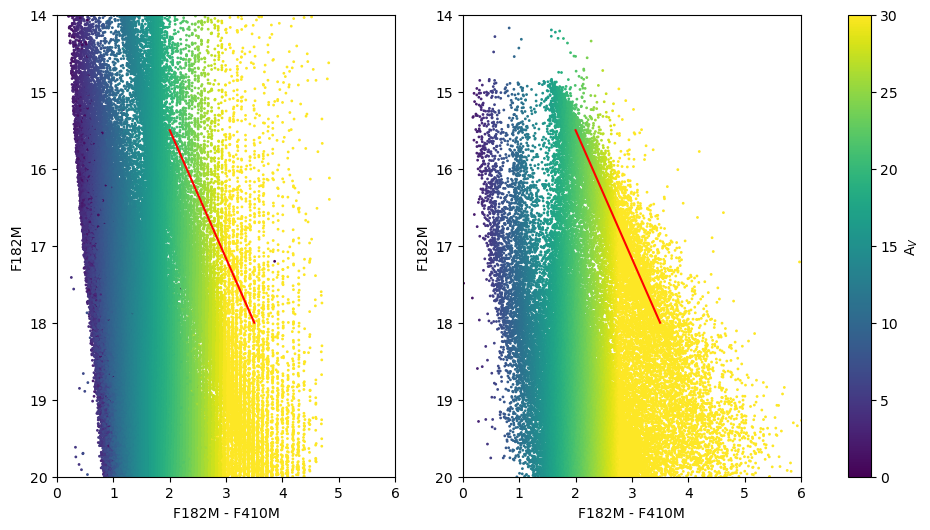

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)

im = ax.scatter(color_182_410[sel], trilegal['eF182M'][sel], c=trilegal['Av'][sel], s=1, vmin=0, vmax=30)
plt.gca().invert_yaxis()
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')
ax.plot([2, 3.5], [15.5, 18], color='red')

ax2 = plt.subplot(122)
cat_use.plot_CMD('F182M', 'F410M', 'F182M', ax=ax2, c=cat_use.get_Av_182410(), s=1, vmin=0, vmax=30)
ax2.plot([2, 3.5], [15.5, 18], color='red')

ax.set_xlim(0, 6)
ax.set_ylim(20, 14)
ax2.set_xlim(0, 6)
ax2.set_ylim(20, 14)

fig.colorbar(im, ax=(ax, ax2), label='A$_V$')
#fig.colorbar(im, ax=ax, label='Distance (kpc)')

#plt.tight_layout()


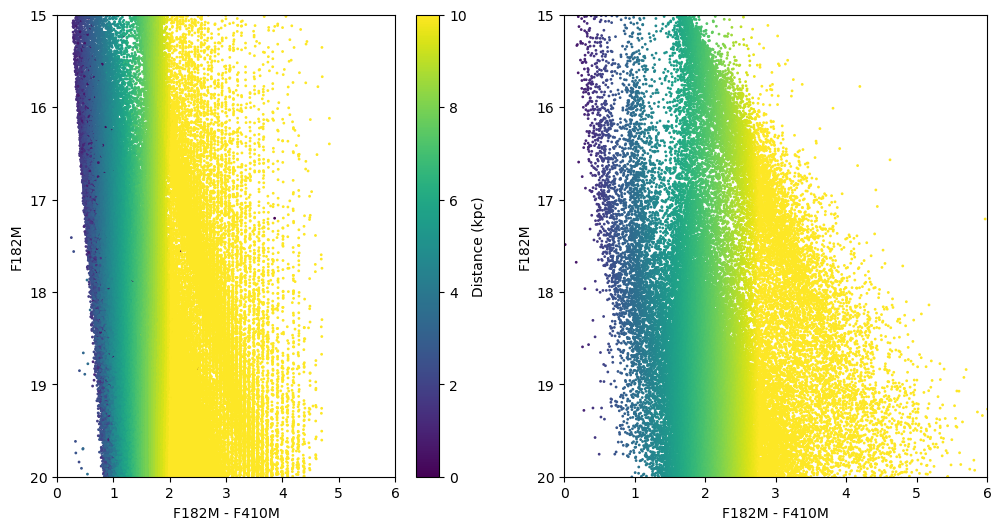

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)

im = ax.scatter(color_182_410[sel], trilegal['eF182M'][sel], c=trilegal['distance'][sel]/1000, s=1, vmin=0, vmax=10)
plt.gca().invert_yaxis()
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')

ax2 = plt.subplot(122)
cat_use.plot_CMD('F182M', 'F410M', 'F182M', ax=ax2, c=cat_use.get_Av_182410(), s=1, vmin=0, vmax=30)

ax.set_xlim(0, 6)
ax.set_ylim(20, 15)
ax2.set_xlim(0, 6)
ax2.set_ylim(20, 15)

#fig.colorbar(im, ax=(ax, ax2), label='A$_V$')
fig.colorbar(im, ax=ax, label='Distance (kpc)')

#plt.tight_layout()


(20.0, 14.0)

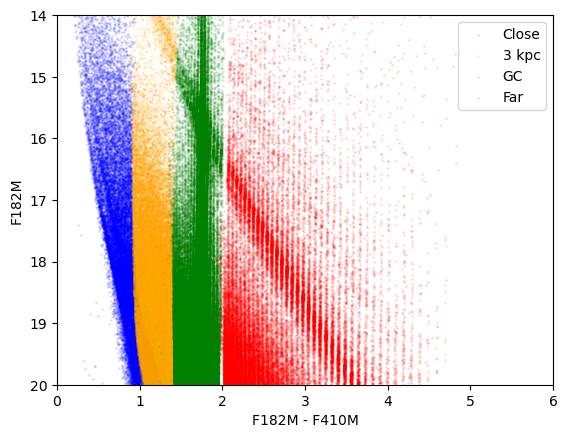

In [ ]:
# distance selections
sel_close = trilegal['distance'] < 4500
sel_3kpc = (trilegal['distance'] < 7000) & (trilegal['distance'] > 4500)
sel_gc = (trilegal['distance'] > 7000) & (trilegal['distance'] < 10000)
sel_far = trilegal['distance'] > 10000

ax = plt.subplot(111)

ax.scatter(color_182_410[sel & sel_close], trilegal['eF182M'][sel & sel_close], c='blue', s=1, label='Close', alpha=0.1)
ax.scatter(color_182_410[sel & sel_3kpc], trilegal['eF182M'][sel & sel_3kpc], c='orange', s=1, label='3 kpc', alpha=0.1)
ax.scatter(color_182_410[sel & sel_gc], trilegal['eF182M'][sel & sel_gc], c='green', s=1, label='GC', alpha=0.1)
ax.scatter(color_182_410[sel & sel_far], trilegal['eF182M'][sel & sel_far], c='red', s=1, label='Far', alpha=0.1)
plt.gca().invert_yaxis()
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')
ax.legend()
ax.set_xlim(0, 6)
ax.set_ylim(20, 14)

In [ ]:
#fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

im = ax.scatter(color_182_410, trilegal['eF182M'], c=trilegal['Av'], s=1, vmin=0, vmax=30)
plt.gca().invert_yaxis()
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')

cbar = plt.colorbar(im, ax=ax, label='Av')

(23.0, 14.5)

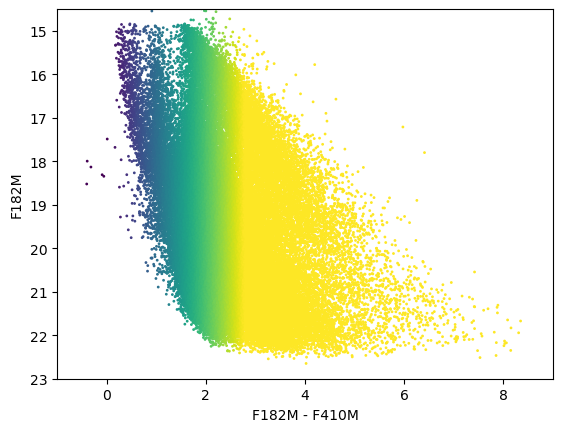

In [ ]:
ax = plt.subplot(111)

cat_use.plot_CMD('F182M', 'F410M', 'F182M', ax=ax, s=1, c=cat_use.get_Av_182410(), vmin=0, vmax=30)
ax.set_xlim(-1, 9)
ax.set_ylim(23, 14.5)

In [ ]:
# h_trilegal / area = h_cat_use / area_cat

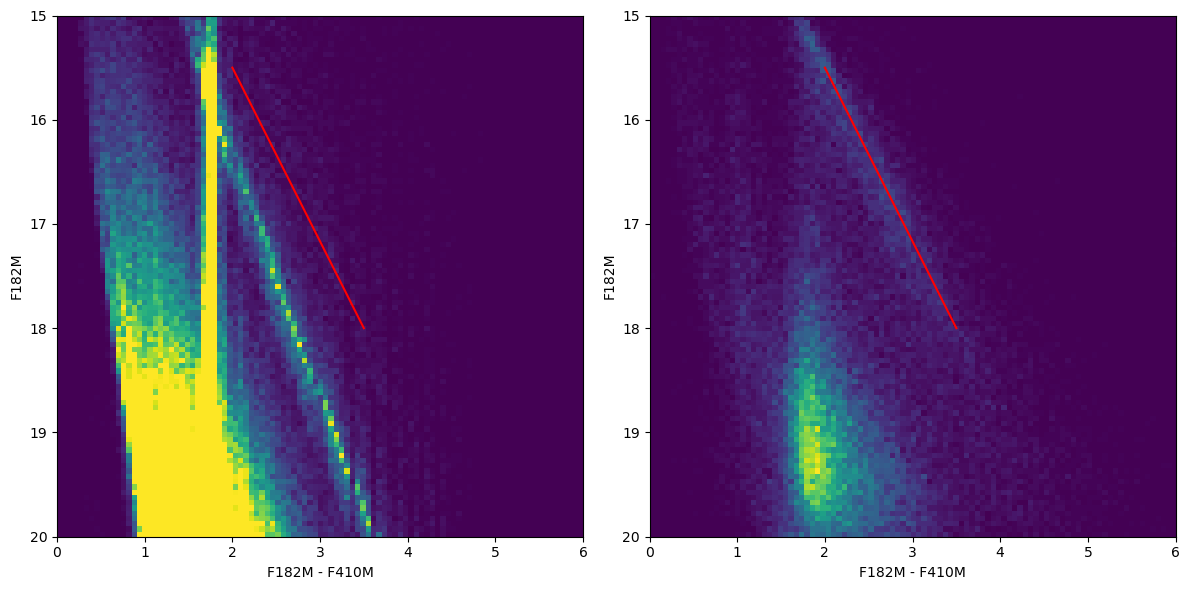

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bins_x = np.linspace(0, 6, 100)
bins_y = np.linspace(15, 20, 100)

h_trilegal, _, __ = np.histogram2d(color_182_410, trilegal['eF182M'], bins=(bins_x, bins_y))
h_cat_use, _, __ = np.histogram2d(cat_use.band('F182M') - cat_use.band('F410M'), cat_use.band('F182M'), bins=(bins_x, bins_y))

h_trilegal = h_trilegal.swapaxes(0, 1)
h_cat_use = h_cat_use.swapaxes(0, 1)

h_trilegal = np.flipud(h_trilegal)
h_cat_use = np.flipud(h_cat_use)

# Plot the 2D histogram for the trilegal data
ax1.imshow(h_trilegal, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 20, 15), vmin=0, vmax=np.max(h_cat_use))
ax1.plot([2, 3.5], [15.5, 18], color='red')
#plt.gca().invert_yaxis()
ax1.set_xlabel('F182M - F410M')
ax1.set_ylabel('F182M')
#fig.colorbar(h1[3], ax=ax1, label='Counts')

# Plot the 2D histogram for the cat_use data
ax2.imshow(h_cat_use, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 20, 15), vmin=0, vmax=np.max(h_cat_use))
ax2.plot([2, 3.5], [15.5, 18], color='red')
#plt.gca().invert_yaxis()
ax2.set_xlabel('F182M - F410M')
ax2.set_ylabel('F182M')
#fig.colorbar(h2[3], ax=ax2, label='Counts')

plt.tight_layout()
plt.show()

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'F182M')

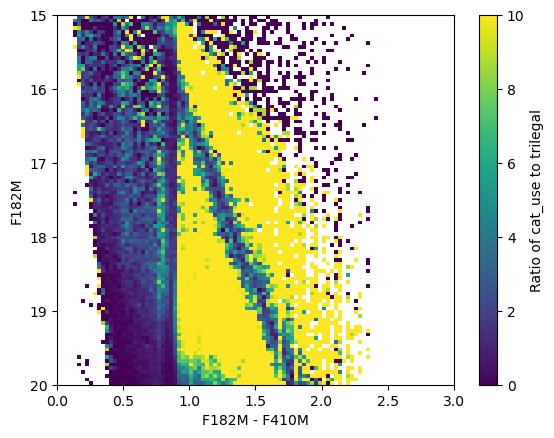

In [ ]:
ratio = h_cat_use / (h_trilegal/(area.to(u.arcsec**2)/area_cat.to(u.arcsec**2)))

ax = plt.subplot(111)
im = ax.imshow(ratio, origin='lower', aspect='auto', cmap='viridis', extent=(0, 3, 20, 15), vmin=0, vmax=10)
plt.colorbar(im, ax=ax, label='Ratio of cat_use to trilegal')
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')

# Find Stellar Density

In [24]:
sel = (trilegal['eF182M'] < 20) & (trilegal['eF182M'] > 13)
sel_cat = (cat_use.band('F182M') < 20) & (cat_use.band('F182M') > 13)

In [23]:
N_stars = len(trilegal[sel])
N_stars

347613

In [26]:
N_stars_cat = len(cat_use.catalog[sel_cat])
N_stars_cat

71159

In [27]:
number_density = N_stars / area
number_density.to(u.arcsec**-2)

<Quantity 0.26821991 1 / arcsec2>

In [71]:
number_density_cat = N_stars_cat / area_cat
number_density_cat.to(u.arcsec**-2)

<Quantity 1.01271024 1 / arcsec2>

In [72]:
unique_distances = trilegal['distance'][sel].unique()
np.nanmax(unique_distances), np.nanmin(unique_distances)

IndexError: Boolean index has wrong length: 131300 instead of 13950136

In [73]:
distances = np.linspace(0, 10, 100) * u.kpc
area = 0.1 * u.deg**2
number_density = np.zeros(len(distances))

for i, distance in enumerate(distances):
    sel = (trilegal['eF182M'] > 15) & (trilegal['eF182M'] < 20) & (trilegal['distance'] < distance.to(u.pc).value)
    number_density[i] = len(trilegal[sel]) / area.to(u.arcsec**2).value


Text(0, 0.5, 'Number Density (star/arcsec$^{-2}$)')

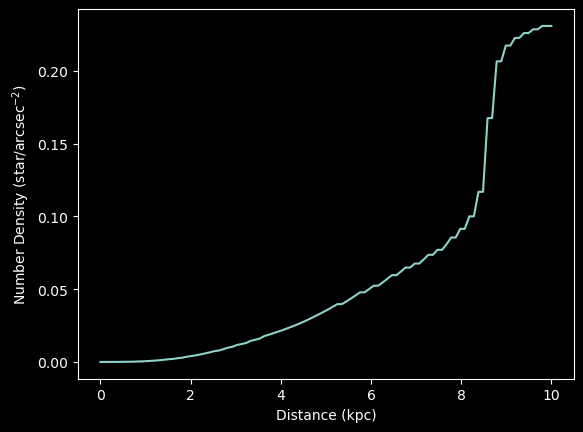

In [74]:
plt.plot(distances, number_density)
plt.xlabel('Distance (kpc)')
plt.ylabel('Number Density (star/arcsec$^{-2}$)')
#plt.axhline(0.16, color='red', linestyle='--')
#plt.axhspan(0.04, 0.39, color='red', alpha=0.2)
#plt.axhline(0.04, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.07, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.10, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.09, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.11, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.20, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.19, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.26, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.15, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.09, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.17, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.18, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.12, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.14, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.15, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.13, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.21, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.07, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.31, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.34, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.08, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.06, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.08, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.17, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.04, color='red', linestyle='--', alpha=0.5)
#plt.axhline(0.29, color='red', linestyle='--', alpha=0.5)
#plt.ylim(0, 0.5)

In [75]:
extinctions = np.linspace(0, 60, 100)
number_density_cat = np.zeros(len(extinctions))
number_density_tri = np.zeros(len(extinctions))

for i, extinction in enumerate(extinctions):
    sel_cat = (cat_use.band('F182M') > 15) & (cat_use.band('F182M') < 20) & (cat_use.get_Av_182410() < extinction)
    number_density_cat[i] = len(cat_use.catalog[sel_cat]) / area_cat.to(u.arcsec**2).value
    sel_tri = (trilegal['eF182M'] > 15) & (trilegal['eF182M'] < 20) & (trilegal['Av'] < extinction)
    number_density_tri[i] = len(trilegal[sel_tri]) / area.to(u.arcsec**2).value

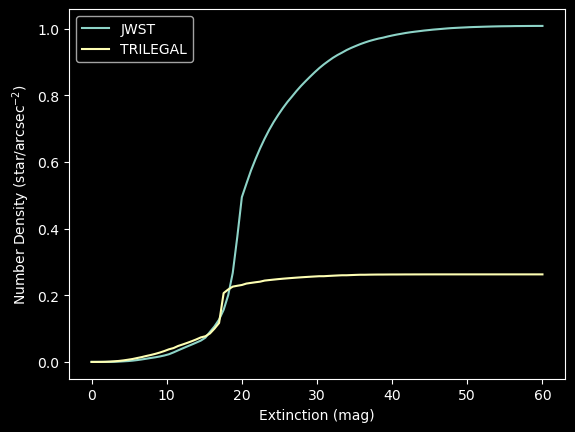

In [76]:
plt.plot(extinctions, number_density_cat, label='JWST')
plt.plot(extinctions, number_density_tri, label='TRILEGAL')
plt.xlabel('Extinction (mag)')
plt.ylabel('Number Density (star/arcsec$^{-2}$)')
plt.legend()

(0.0, 100.0)

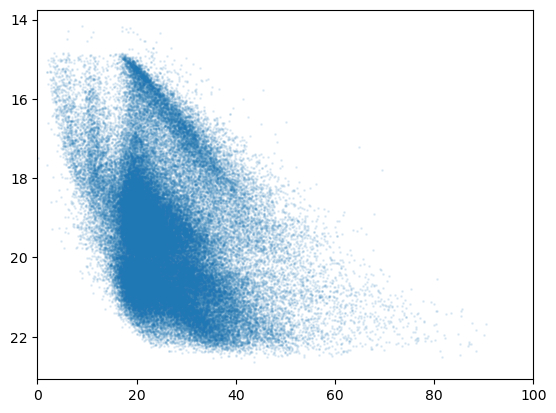

In [ ]:
plt.scatter(cat_use.get_Av_182410(), cat_use.band('F182M'), s=1, alpha=0.1)
plt.gca().invert_yaxis()
plt.xlim(0, 100)

# Masking CMD by region

In [86]:
fn_405 = f'/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d-perfilt64.fits'
ww = WCS(fits.open(fn_405)[0].header)
reg = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/extincted_regions.reg')
reg_mask = cat_use.get_region_mask(reg, ww)

In [87]:
cat_use_cloud = JWSTCatalog(cat_use.apply_mask(reg_mask))
cat_use_clear = JWSTCatalog(cat_use.apply_mask(~reg_mask))

(0.0, 9.0)

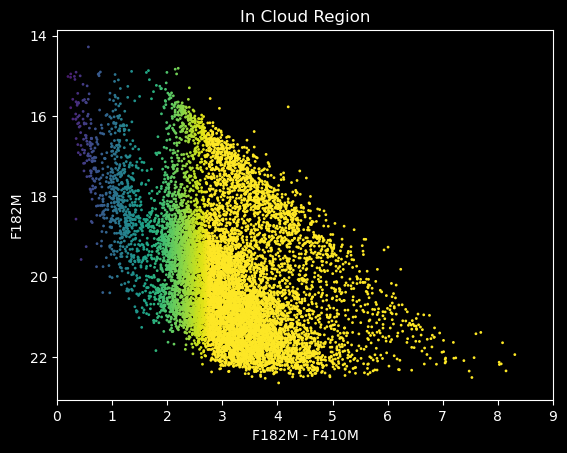

In [88]:
ax = plt.subplot(111)
cat_use_cloud.plot_CMD('F182M', 'F410M', 'F182M', c=cat_use_cloud.get_Av_182410(), s=1, vmin=0, vmax=30)
ax.set_title('In Cloud Region')
ax.set_xlim(0, 9)

(0.0, 9.0)

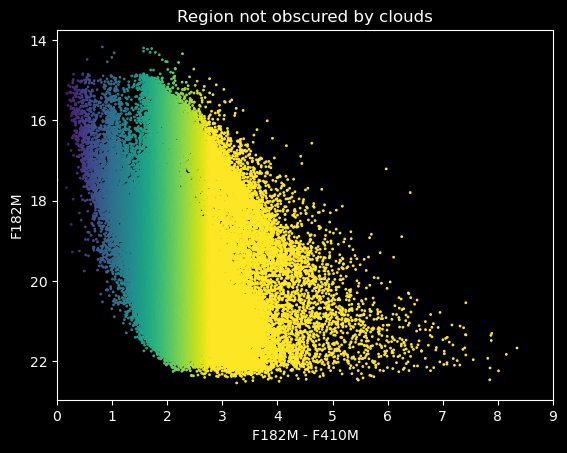

In [89]:
ax = plt.subplot(111)
cat_use_clear.plot_CMD('F182M', 'F410M', 'F182M', c=cat_use_clear.get_Av_182410(), s=1, vmin=0, vmax=30)
ax.set_title('Region not obscured by clouds')
ax.set_xlim(0, 9)

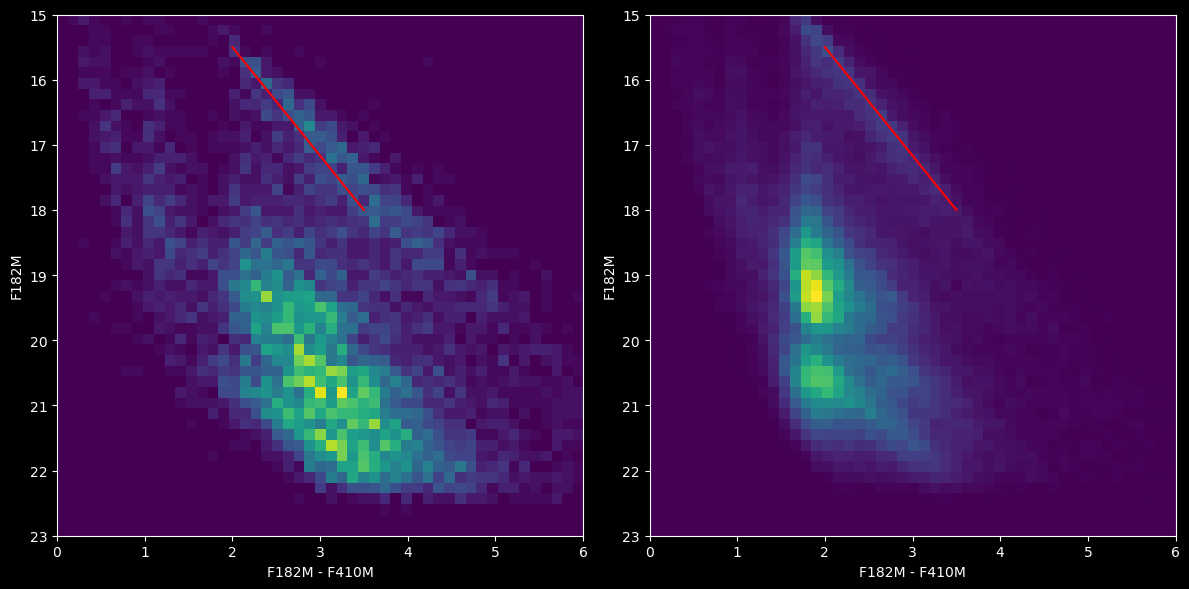

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bins_x = np.linspace(0, 6, 50)
bins_y = np.linspace(15, 23, 50)

h_cloud, _, __ = np.histogram2d(cat_use_cloud.color('F182M','F410M'), cat_use_cloud.band('F182M'), bins=(bins_x, bins_y))
h_clear, _, __ = np.histogram2d(cat_use_clear.color('F182M','F410M'), cat_use_clear.band('F182M'), bins=(bins_x, bins_y))

h_cloud = h_cloud.swapaxes(0, 1)
h_clear = h_clear.swapaxes(0, 1)

h_cloud = np.flipud(h_cloud)
h_clear = np.flipud(h_clear)

ax1.imshow(h_cloud, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 23, 15), vmin=0, vmax=np.max(h_cloud))
ax1.plot([2, 3.5], [15.5, 18], color='red')
ax1.set_xlabel('F182M - F410M')
ax1.set_ylabel('F182M')

ax2.imshow(h_clear, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 23, 15), vmin=0, vmax=np.max(h_clear))
ax2.plot([2, 3.5], [15.5, 18], color='red')
ax2.set_xlabel('F182M - F410M')
ax2.set_ylabel('F182M')

plt.tight_layout()
plt.show()

In [91]:
# Convert the region to pixel coordinates
reg_pixel_area = reg[0].to_pixel(ww).area*u.pixel**2* ww.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)
reg_pixel_area

<Quantity 9433.65340553 arcsec2>

In [92]:
data_405 = fits.getdata(fn_405)
image_area = np.sum((data_405 != 0) & (np.isnan(data_405) == False)) * ww.proj_plane_pixel_area().to(u.arcsec**2)
print(image_area)

73296.66969706582 arcsec2


/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'F182M')

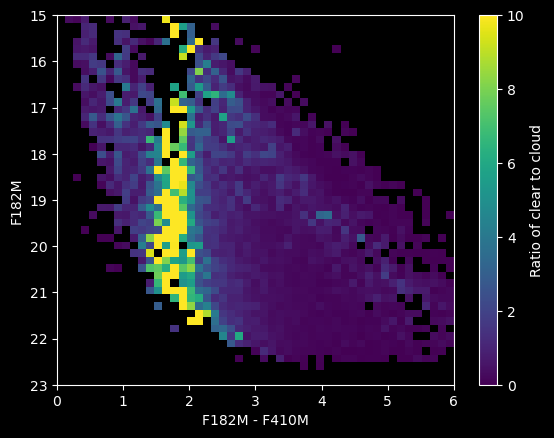

In [93]:
plt.style.use('dark_background')

ratio = h_clear / (h_cloud/(reg_pixel_area/(image_area-reg_pixel_area)))

ax = plt.subplot(111)
im = ax.imshow(ratio, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 23, 15), vmin=0, vmax=10)
plt.colorbar(im, ax=ax, label='Ratio of clear to cloud')
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')

Text(0, 0.5, 'F182M')

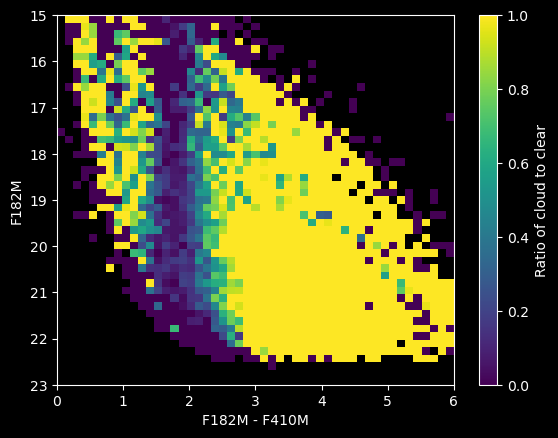

In [94]:
ratio = h_cloud / (h_clear/((image_area-reg_pixel_area)/reg_pixel_area))

ax = plt.subplot(111)
im = ax.imshow(ratio, origin='lower', aspect='auto', cmap='viridis', extent=(0, 6, 23, 15), vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label='Ratio of cloud to clear')
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F182M')

In [95]:
extinctions = np.linspace(0, 60, 100)
number_density_clear = np.zeros(len(extinctions))
number_density_cloud = np.zeros(len(extinctions))

for i, extinction in enumerate(extinctions):
    sel_clear = (cat_use_clear.band('F182M') > 15) & (cat_use_clear.band('F182M') < 20) & (cat_use_clear.get_Av_182410() < extinction)
    number_density_clear[i] = len(cat_use_clear.catalog[sel_clear]) / (image_area-reg_pixel_area).value
    sel_cloud = (cat_use_cloud.band('F182M') > 15) & (cat_use_cloud.band('F182M') < 20) & (cat_use_cloud.get_Av_182410() < extinction)
    number_density_cloud[i] = len(cat_use_cloud.catalog[sel_cloud]) / reg_pixel_area.value

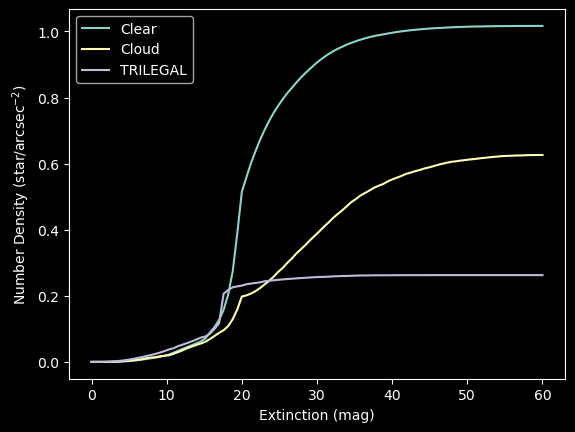

: 

In [ ]:
plt.plot(extinctions, number_density_clear, label='Clear')
plt.plot(extinctions, number_density_cloud, label='Cloud')
plt.plot(extinctions, number_density_tri, label='TRILEGAL')
#plt.plot(extinctions, number_density_cat, label='JWST')

plt.xlabel('Extinction (mag)')
plt.ylabel('Number Density (star/arcsec$^{-2}$)')
plt.legend()

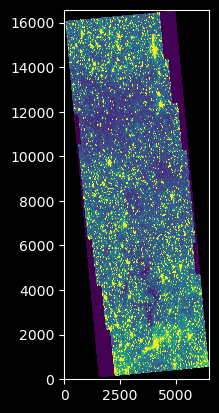

In [59]:
plt.imshow(data_405, origin='lower', cmap='viridis', vmin=0, vmax=50)